<a href="https://colab.research.google.com/github/Volks44/Proj_Lab1/blob/main/2_RestNet50_%26_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install np_utils --quiet
import keras
from keras.datasets import cifar10
import np_utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
# Classes division
classes_for_clas = [0, 1, 2, 3, 4, 5]
classes_for_clus = [6,7,8,9]

# Filtering the data for classification
train_mask = np.isin(train_labels, classes_for_clas).flatten()
test_mask = np.isin(test_labels, classes_for_clas).flatten()

x_train_clas = train_images[train_mask]
y_train_clas = train_labels[train_mask]

x_test_clas = test_images[test_mask]
y_test_clas = test_labels[test_mask]

# Filtering the data for clustering
train_mask = np.isin(train_labels, classes_for_clus).flatten()
test_mask = np.isin(test_labels, classes_for_clus).flatten()

x_train_clus = train_images[train_mask]
y_train_clus = train_labels[train_mask]

x_test_clus = test_images[test_mask]
y_test_clus = test_labels[test_mask]

In [5]:
# break training set into training and validation sets
(x_train_clas, x_valid_clas) = x_train_clas[5000:], x_train_clas[:5000]
(y_train_clas, y_valid_clas) = y_train_clas[5000:], y_train_clas[:5000]

# print shape of training set
print('x_train shape:', x_train_clas.shape)

# print number of training, validation, and test images
print(x_train_clas.shape[0], 'train samples')
print(x_test_clas.shape[0], 'test samples')
print(x_valid_clas.shape[0], 'validation samples')

x_train shape: (25000, 32, 32, 3)
25000 train samples
6000 test samples
5000 validation samples


In [6]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [23]:
x_train_clas = preprocess_image_input(x_train_clas)
x_valid_clas = preprocess_image_input(x_valid_clas)

In [8]:
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [9]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [10]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [11]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [12]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
# training
batch_size = 64
epochs=10

checkpointer = ModelCheckpoint(filepath='model.RestNet50.hdf5', verbose=1, save_best_only=True)

optimizer = Adam(learning_rate=0.0005)

history = model.fit(x_train_clas, y_train_clas, epochs=epochs, validation_data = (x_valid_clas, y_valid_clas), batch_size=batch_size)

Epoch 1/10
391/391 [==============================] - 315s 688ms/step - loss: 0.4256 - accuracy: 0.8546 - val_loss: 0.2491 - val_accuracy: 0.9044
Epoch 2/10
391/391 [==============================] - 267s 682ms/step - loss: 0.1121 - accuracy: 0.9619 - val_loss: 0.1841 - val_accuracy: 0.9362
Epoch 3/10
391/391 [==============================] - 260s 664ms/step - loss: 0.0370 - accuracy: 0.9894 - val_loss: 0.1693 - val_accuracy: 0.9426
Epoch 4/10
391/391 [==============================] - 267s 682ms/step - loss: 0.0138 - accuracy: 0.9973 - val_loss: 0.1806 - val_accuracy: 0.9472
Epoch 5/10
391/391 [==============================] - 266s 682ms/step - loss: 0.0077 - accuracy: 0.9986 - val_loss: 0.1734 - val_accuracy: 0.9516
Epoch 6/10
391/391 [==============================] - 266s 681ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.1897 - val_accuracy: 0.9492
Epoch 7/10
391/391 [==============================] - 267s 682ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.1881 -

In [13]:
loss, accuracy = model.evaluate(x_valid_clas, y_valid_clas, batch_size=64)


79/79 [==============================] - 14s 174ms/step - loss: 0.1993 - accuracy: 0.9502


In [26]:
# one-hot encode the labels
num_classes = len(np.unique(y_train_clas))
y_test_clas = keras.utils.to_categorical(y_test_clas, num_classes)

188/188 [==============================] - 16s 87ms/step


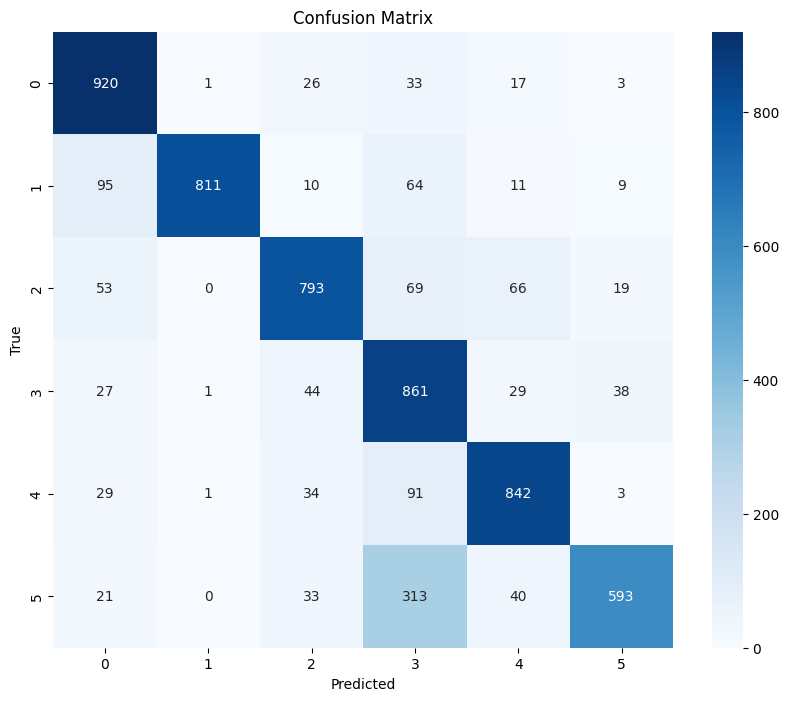


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1000
           1       1.00      0.81      0.89      1000
           2       0.84      0.79      0.82      1000
           3       0.60      0.86      0.71      1000
           4       0.84      0.84      0.84      1000
           5       0.89      0.59      0.71      1000

    accuracy                           0.80      6000
   macro avg       0.83      0.80      0.81      6000
weighted avg       0.83      0.80      0.81      6000



In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Make predictions
predictions = model.predict(x_test_clas)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_clas, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
pyplot.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(6), yticklabels=np.arange(6))
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Confusion Matrix')
pyplot.show()

# Print classification report
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)

Clustering

In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [15]:
X = x_train_clus.reshape(x_train_clus.shape[0], -1)
y = y_train_clus.reshape(-1)

In [16]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

In [17]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_tsne)
y_predX_tsne = kmeans.predict(X_tsne)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


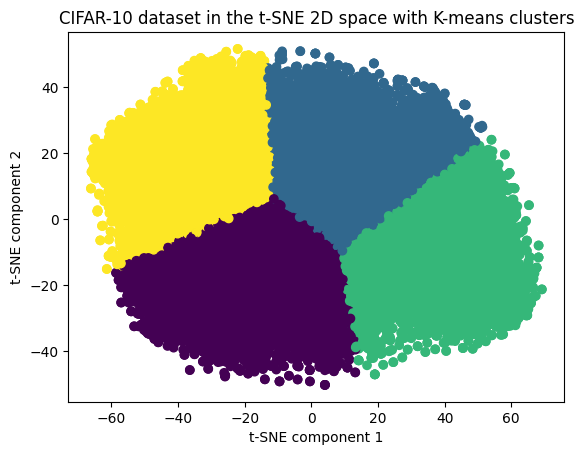

In [18]:
from matplotlib import pyplot
pyplot.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_predX_tsne)
pyplot.xlabel('t-SNE component 1')
pyplot.ylabel('t-SNE component 2')
pyplot.title('CIFAR-10 dataset in the t-SNE 2D space with K-means clusters')
pyplot.show()